## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [1]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df['state'].value_counts()/len(df)*100

isolated    80.748422
released    13.841298
deceased     1.442741
Name: state, dtype: float64

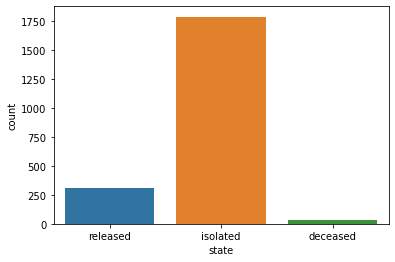

In [7]:
sns.countplot(df['state'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             2218 non-null   int64  
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [12]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
dtype: int64

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [13]:
df['disease']=df['disease'].fillna(value=0)
df['disease']=df['disease'].replace(True,1)
df['disease'].value_counts()

0    2199
1      19
Name: disease, dtype: int64

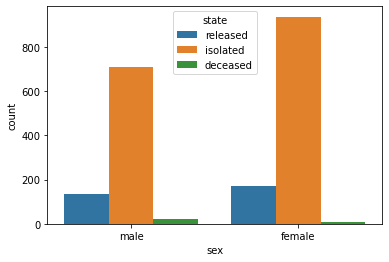

In [14]:
sns.countplot('sex',hue='state',data=df)

In [15]:
df['sex'].value_counts()

female    1171
male       902
Name: sex, dtype: int64

In [16]:
df['sex']=df['sex'].fillna('female')
df['sex'].value_counts()

female    1316
male       902
Name: sex, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [17]:
df['n_age']=2020-df['birth_year']
df['n_age']

0       56.0
1       33.0
2       56.0
3       29.0
4       28.0
        ... 
2213    30.0
2214    22.0
2215    22.0
2216    48.0
2217    46.0
Name: n_age, Length: 2218, dtype: float64

In [18]:
df[['age','n_age']]

,age,n_age
0,50s,56.0
1,30s,33.0
2,50s,56.0
3,20s,29.0
4,20s,28.0
...,...,...
2213,30s,30.0
2214,20s,22.0
2215,20s,22.0
2216,40s,48.0


In [19]:
df1=df[df['birth_year'].isnull() & df['age'].notnull()]
df1

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
446,1300000001,16.0,female,NaN,40s,Korea,Gwangju,NaN,0,NaN,NaN,NaN,450.0,2020-01-27,2020-02-04,2020-02-20,NaN,released,NaN
447,1300000002,18.0,female,NaN,20s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,8.0,NaN,2020-02-05,2020-02-20,NaN,released,NaN
448,1300000003,126.0,male,NaN,30s,Korea,Gwangju,NaN,0,etc,NaN,NaN,65.0,NaN,2020-02-20,NaN,NaN,isolated,NaN
449,1300000004,164.0,male,NaN,30s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,30.0,NaN,2020-02-21,2020-03-18,NaN,released,NaN
450,1300000005,210.0,male,NaN,30s,Korea,Gwangju,NaN,0,etc,NaN,NaN,156.0,NaN,2020-02-21,2020-03-16,NaN,released,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,6023000043,NaN,female,NaN,20s,Korea,Gyeongsangbuk-do,Pohang-si,0,NaN,NaN,NaN,NaN,NaN,2020-03-07,NaN,NaN,isolated,NaN
2125,6023000044,NaN,male,NaN,10s,Korea,Gyeongsangbuk-do,Pohang-si,0,NaN,NaN,NaN,NaN,NaN,2020-03-08,NaN,NaN,isolated,NaN
2126,6023000045,NaN,male,NaN,0s,Korea,Gyeongsangbuk-do,Pohang-si,0,NaN,NaN,NaN,NaN,NaN,2020-03-08,NaN,NaN,isolated,NaN
2127,6023000046,NaN,female,NaN,60s,Korea,Gyeongsangbuk-do,Pohang-si,0,contact with patient,NaN,6.023000e+09,NaN,NaN,2020-03-09,NaN,NaN,isolated,NaN


In [20]:
df2=df[~(df['birth_year'].isnull() & df['age'].notnull())]
df2

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,6100000085,NaN,male,1990.0,30s,Korea,Gyeongsangnam-do,Changwon-si,0,NaN,NaN,NaN,NaN,NaN,2020-03-16,NaN,NaN,NaN,30.0
2214,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,0,etc,NaN,NaN,87.0,NaN,2020-02-20,NaN,NaN,isolated,22.0
2215,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,0,etc,NaN,NaN,84.0,NaN,2020-02-22,2020-03-07,NaN,released,22.0
2216,7000000003,4345.0,female,1972.0,40s,Korea,Jeju-do,etc,0,etc,NaN,NaN,21.0,NaN,2020-03-02,2020-03-15,NaN,released,48.0


In [21]:
pd.concat([df1,df2])

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
446,1300000001,16.0,female,NaN,40s,Korea,Gwangju,NaN,0,NaN,NaN,NaN,450.0,2020-01-27,2020-02-04,2020-02-20,NaN,released,NaN
447,1300000002,18.0,female,NaN,20s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,8.0,NaN,2020-02-05,2020-02-20,NaN,released,NaN
448,1300000003,126.0,male,NaN,30s,Korea,Gwangju,NaN,0,etc,NaN,NaN,65.0,NaN,2020-02-20,NaN,NaN,isolated,NaN
449,1300000004,164.0,male,NaN,30s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,30.0,NaN,2020-02-21,2020-03-18,NaN,released,NaN
450,1300000005,210.0,male,NaN,30s,Korea,Gwangju,NaN,0,etc,NaN,NaN,156.0,NaN,2020-02-21,2020-03-16,NaN,released,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,6100000085,NaN,male,1990.0,30s,Korea,Gyeongsangnam-do,Changwon-si,0,NaN,NaN,NaN,NaN,NaN,2020-03-16,NaN,NaN,NaN,30.0
2214,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,0,etc,NaN,NaN,87.0,NaN,2020-02-20,NaN,NaN,isolated,22.0
2215,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,0,etc,NaN,NaN,84.0,NaN,2020-02-22,2020-03-07,NaN,released,22.0
2216,7000000003,4345.0,female,1972.0,40s,Korea,Jeju-do,etc,0,etc,NaN,NaN,21.0,NaN,2020-03-02,2020-03-15,NaN,released,48.0


In [22]:
df1['new_age']=df1['age'].str[:-1].astype('Float32').astype(int)
df1['new_age']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


446     40
447     20
448     30
449     30
450     30
        ..
2124    20
2125    10
2126     0
2127    60
2128     0
Name: new_age, Length: 303, dtype: int32

In [23]:
df1['birth_year']=2020-df1['new_age']
df1['birth_year']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


446     1980
447     2000
448     1990
449     1990
450     1990
        ... 
2124    2000
2125    2010
2126    2020
2127    1960
2128    2020
Name: birth_year, Length: 303, dtype: int32

In [24]:
df1=df1.drop('new_age', axis=1)

In [25]:
df=pd.concat([df1,df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2218 entries, 446 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2218 non-null   object 
 3   birth_year          2067 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             2218 non-null   int64  
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  dece

In [26]:
df['n_age']=2020-df['birth_year']
df['n_age']

446     40.0
447     20.0
448     30.0
449     30.0
450     30.0
        ... 
2213    30.0
2214    22.0
2215    22.0
2216    48.0
2217    46.0
Name: n_age, Length: 2218, dtype: float64

In [27]:
df=df.dropna(subset=['birth_year'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 446 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2067 non-null   int64  
 1   global_num          1311 non-null   float64
 2   sex                 2067 non-null   object 
 3   birth_year          2067 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2067 non-null   object 
 6   province            2067 non-null   object 
 7   city                2005 non-null   object 
 8   disease             2067 non-null   int64  
 9   infection_case      1157 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      406 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2066 non-null   object 
 15  released_date       221 non-null    object 
 16  dece

In [28]:
df['infection_case'].value_counts()

contact with patient                530
etc                                 218
Guro-gu Call Center                 102
Shincheonji Church                   82
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
Pilgrimage to Israel                  1
River of Grace Community Church       1
Name: infection_case, dtype: int64

In [29]:
df['infection_case'].isnull().sum()

910

In [30]:
df['infection_case'].value_counts()

contact with patient                530
etc                                 218
Guro-gu Call Center                 102
Shincheonji Church                   82
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
Pilgrimage to Israel                  1
River of Grace Community Church       1
Name: infection_case, dtype: int64

In [31]:
df1=df[df['infection_case']=='contact with patient']
df2=df[~(df['infection_case']=='contact with patient')]

In [32]:
df2['infection_case']='other'
df2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
446,1300000001,16.0,female,1980.0,40s,Korea,Gwangju,NaN,0,other,NaN,NaN,450.0,2020-01-27,2020-02-04,2020-02-20,NaN,released,40.0
448,1300000003,126.0,male,1990.0,30s,Korea,Gwangju,NaN,0,other,NaN,NaN,65.0,NaN,2020-02-20,NaN,NaN,isolated,30.0
450,1300000005,210.0,male,1990.0,30s,Korea,Gwangju,NaN,0,other,NaN,NaN,156.0,NaN,2020-02-21,2020-03-16,NaN,released,30.0
458,1300000013,5031.0,male,1970.0,50s,Korea,Gwangju,NaN,0,other,NaN,NaN,30.0,2020-02-27,2020-03-04,NaN,NaN,isolated,50.0
461,1300000016,8141.0,female,1980.0,40s,Korea,Gwangju,NaN,0,other,NaN,NaN,23.0,NaN,2020-03-14,NaN,NaN,isolated,40.0


In [33]:
df=pd.concat([df1,df2])
df

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
447,1300000002,18.0,female,2000.0,20s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,8.0,NaN,2020-02-05,2020-02-20,NaN,released,20.0
449,1300000004,164.0,male,1990.0,30s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,30.0,NaN,2020-02-21,2020-03-18,NaN,released,30.0
451,1300000006,239.0,male,1990.0,30s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,14.0,NaN,2020-02-21,2020-03-16,NaN,released,30.0
452,1300000007,489.0,male,1990.0,30s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,39.0,NaN,2020-02-22,2020-03-17,NaN,released,30.0
453,1300000008,589.0,female,1990.0,30s,Korea,Gwangju,NaN,0,contact with patient,NaN,1.300000e+09,47.0,NaN,2020-02-22,2020-03-06,NaN,released,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,6100000085,NaN,male,1990.0,30s,Korea,Gyeongsangnam-do,Changwon-si,0,other,NaN,NaN,NaN,NaN,2020-03-16,NaN,NaN,NaN,30.0
2214,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,0,other,NaN,NaN,87.0,NaN,2020-02-20,NaN,NaN,isolated,22.0
2215,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,0,other,NaN,NaN,84.0,NaN,2020-02-22,2020-03-07,NaN,released,22.0
2216,7000000003,4345.0,female,1972.0,40s,Korea,Jeju-do,etc,0,other,NaN,NaN,21.0,NaN,2020-03-02,2020-03-15,NaN,released,48.0


In [34]:
df=df.drop('infection_order', axis=1)

In [35]:
df['infected_by']=df['infected_by'].fillna(df['infected_by'].mean())

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 447 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2067 non-null   int64  
 1   global_num          1311 non-null   float64
 2   sex                 2067 non-null   object 
 3   birth_year          2067 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2067 non-null   object 
 6   province            2067 non-null   object 
 7   city                2005 non-null   object 
 8   disease             2067 non-null   int64  
 9   infection_case      2067 non-null   object 
 10  infected_by         2067 non-null   float64
 11  contact_number      406 non-null    float64
 12  symptom_onset_date  193 non-null    object 
 13  confirmed_date      2066 non-null   object 
 14  released_date       221 non-null    object 
 15  deceased_date       32 non-null     object 
 16  stat

In [37]:
df['city'].value_counts()

Gyeongsan-si    535
Cheonan-si       98
Seongnam-si      89
Gumi-si          59
Chilgok-gun      49
               ... 
Gwangyang-si      1
Suncheon-si       1
Hamyang-gun       1
Dalseong-gun      1
Namhae-gun        1
Name: city, Length: 128, dtype: int64

In [38]:
df=df.drop('city',axis=1)

In [39]:
df=df.drop(['global_num','birth_year','contact_number','symptom_onset_date','confirmed_date','released_date', 'deceased_date','age'],axis=1)

In [40]:
df.isnull().sum()/len(df)

patient_id        0.000000
sex               0.000000
country           0.000000
province          0.000000
disease           0.000000
infection_case    0.000000
infected_by       0.000000
state             0.042574
n_age             0.000000
dtype: float64

In [41]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,sex,country,province,disease,infection_case,infected_by,state,n_age


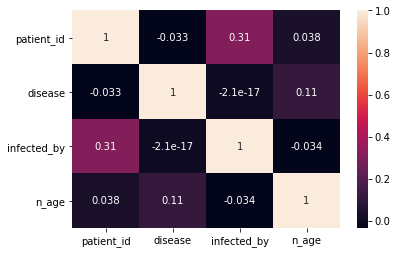

In [42]:
sns.heatmap(df.corr(), annot=True)

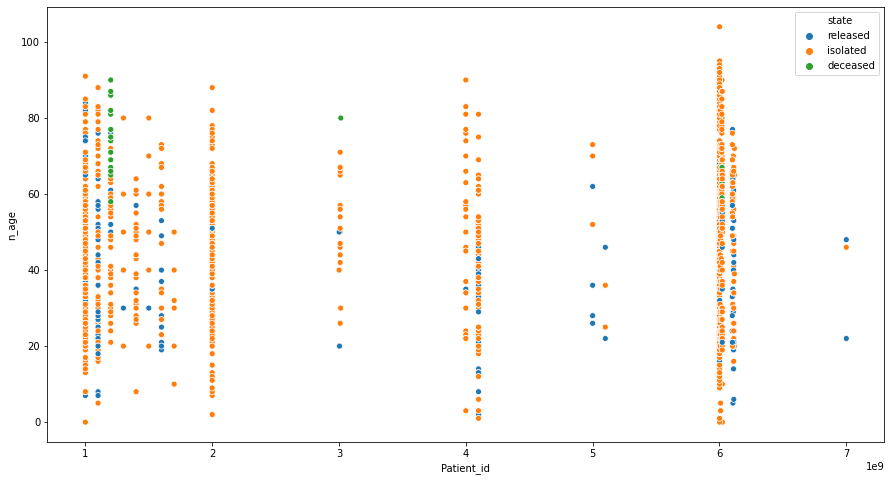

In [43]:
plt.figure(figsize=(15,8))
_plt=sns.scatterplot(x='patient_id', y='n_age', hue='state', data=df)
_plt=plt.xlabel('Patient_id')
_plt=plt.ylabel('n_age')

Review the range of values per column.

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2067.0,3.871651e+09,2.201983e+09,1.000000e+09,1.500000e+09,4.100000e+09,6.001000e+09,7.000000e+09
disease,2067.0,9.192066e-03,9.545669e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infected_by,2067.0,2.600789e+09,7.475391e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
n_age,2067.0,4.420416e+01,1.944603e+01,0.000000e+00,2.700000e+01,4.400000e+01,5.800000e+01,1.040000e+02


KeyError: "None of [Index(['birth_year'], dtype='object')] are in the [columns]"

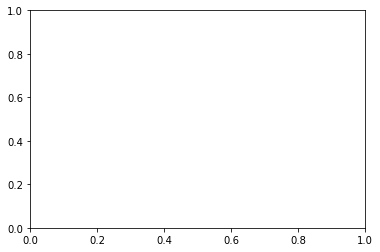

In [45]:
df.boxplot(['birth_year'])

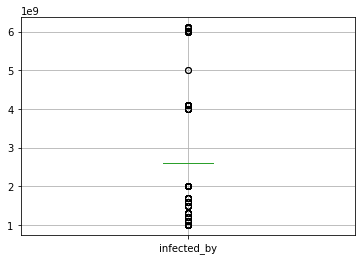

In [47]:
df.boxplot(['infected_by'])

### Check for duplicated rows

In [48]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,sex,country,province,disease,infection_case,infected_by,state,n_age


In [49]:
df.select_dtypes('object').nunique()

sex                2
country            4
province          17
infection_case     2
state              3
dtype: int64

In [50]:
df.select_dtypes('object').columns

Index(['sex', 'country', 'province', 'infection_case', 'state'], dtype='object')

In [51]:
columns=['sex', 'country', 'province', 'infection_case']
dummies=pd.get_dummies(df[columns], drop_first=True)
df=pd.concat([df,dummies],axis=1)
df=df.drop(columns, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 447 to 2217
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   patient_id                  2067 non-null   int64  
 1   disease                     2067 non-null   int64  
 2   infected_by                 2067 non-null   float64
 3   state                       1979 non-null   object 
 4   n_age                       2067 non-null   float64
 5   sex_male                    2067 non-null   uint8  
 6   country_Korea               2067 non-null   uint8  
 7   country_Mongolia            2067 non-null   uint8  
 8   country_Thailand            2067 non-null   uint8  
 9   province_Chungcheongbuk-do  2067 non-null   uint8  
 10  province_Chungcheongnam-do  2067 non-null   uint8  
 11  province_Daegu              2067 non-null   uint8  
 12  province_Daejeon            2067 non-null   uint8  
 13  province_Gangwon-do         206

In [52]:
Prediction=df[df['state'].isnull()]
Prediction=Prediction.drop('state',axis=1)
Prediction

,patient_id,disease,infected_by,n_age,sex_male,country_Korea,country_Mongolia,country_Thailand,province_Chungcheongbuk-do,province_Chungcheongnam-do,...,province_Gyeongsangbuk-do,province_Gyeongsangnam-do,province_Incheon,province_Jeju-do,province_Jeollabuk-do,province_Jeollanam-do,province_Sejong,province_Seoul,province_Ulsan,infection_case_other
802,2000000214,0,2.000000e+09,53.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
803,2000000215,0,2.000000e+09,46.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
805,2000000217,0,2.000000e+09,66.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
806,2000000218,0,2.000000e+09,28.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
807,2000000219,0,2.000000e+09,64.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2000000294,0,2.600789e+09,34.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
884,2000000296,0,2.600789e+09,33.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
887,2000000299,0,2.600789e+09,35.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
888,2000000300,0,2.600789e+09,31.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [53]:
Noprediction=df[df['state'].notnull()]
Noprediction

,patient_id,disease,infected_by,state,n_age,sex_male,country_Korea,country_Mongolia,country_Thailand,province_Chungcheongbuk-do,...,province_Gyeongsangbuk-do,province_Gyeongsangnam-do,province_Incheon,province_Jeju-do,province_Jeollabuk-do,province_Jeollanam-do,province_Sejong,province_Seoul,province_Ulsan,infection_case_other
447,1300000002,0,1.300000e+09,released,20.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
449,1300000004,0,1.300000e+09,released,30.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451,1300000006,0,1.300000e+09,released,30.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
452,1300000007,0,1.300000e+09,released,30.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
453,1300000008,0,1.300000e+09,released,30.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,6101000084,0,2.600789e+09,isolated,49.0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2214,7000000001,0,2.600789e+09,isolated,22.0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2215,7000000002,0,2.600789e+09,released,22.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2216,7000000003,0,2.600789e+09,released,48.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


### Split the data into test and train subsamples

In [54]:
Noprediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1979 entries, 447 to 2217
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   patient_id                  1979 non-null   int64  
 1   disease                     1979 non-null   int64  
 2   infected_by                 1979 non-null   float64
 3   state                       1979 non-null   object 
 4   n_age                       1979 non-null   float64
 5   sex_male                    1979 non-null   uint8  
 6   country_Korea               1979 non-null   uint8  
 7   country_Mongolia            1979 non-null   uint8  
 8   country_Thailand            1979 non-null   uint8  
 9   province_Chungcheongbuk-do  1979 non-null   uint8  
 10  province_Chungcheongnam-do  1979 non-null   uint8  
 11  province_Daegu              1979 non-null   uint8  
 12  province_Daejeon            1979 non-null   uint8  
 13  province_Gangwon-do         197

In [55]:
from sklearn.model_selection import train_test_split
X=Noprediction.drop(['state','patient_id'], axis=1)
y=Noprediction['state']
# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=101)

### Scale data to prep for model creation

In [56]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_to_predict_test_scaled=scaler.transform(Prediction.drop('patient_id', axis=1))

In [57]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [58]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 101,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.836
Random Forest: f1-score=0.809


In [59]:
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred,y_test))

              precision    recall  f1-score   support

    deceased       0.89      0.89      0.89         9
    isolated       0.96      0.85      0.90       357
    released       0.27      0.63      0.38        30

    accuracy                           0.84       396
   macro avg       0.71      0.79      0.72       396
weighted avg       0.91      0.84      0.86       396

[[  8   1   0]
 [  1 304  52]
 [  0  11  19]]


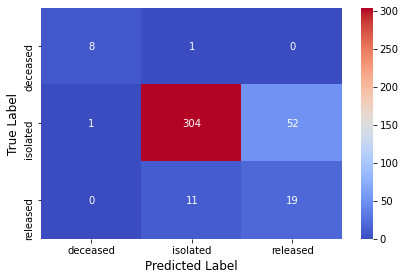

In [77]:
_plt=sns.heatmap(confusion_matrix(y_pred,y_test), annot=True, fmt='d', xticklabels=['deceased','isolated','released'],yticklabels=['deceased','isolated','released'],cmap='coolwarm')
_plt=plt.xlabel('Predicted Label', fontsize=12)
_plt=plt.ylabel('True Label',fontsize=12)
plt.tight_layout()

In [67]:
y_predicted = model_res.predict(X_to_predict_test_scaled)

In [68]:
np.unique(y_predicted,return_counts=True) 

(array(['isolated', 'released'], dtype=object), array([85,  3], dtype=int64))

**Model Predicted that the patient with the missing state are 85 isolated and 3 released.**

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [69]:
class_names=['isolated','released','deceased'] # name  of classes

Confusion matrix, without normalization
[[  8   1   0]
 [  1 304  11]
 [  0  52  19]]
Normalized confusion matrix
[[0.89 0.11 0.  ]
 [0.   0.96 0.03]
 [0.   0.73 0.27]]


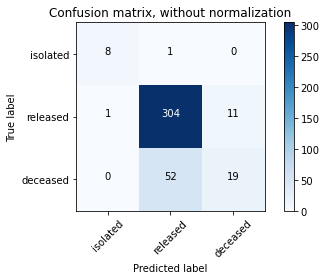

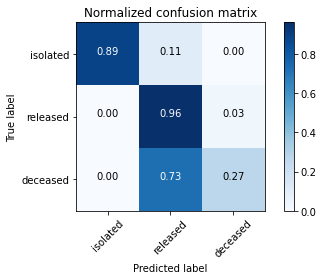

In [70]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

In [71]:
feature_importance = clf.feature_importances_
feature_importance

array([5.02e-02, 9.95e-02, 5.58e-01, 4.32e-02, 1.57e-02, 1.73e-03,
       1.65e-04, 4.48e-03, 1.03e-02, 2.48e-02, 9.19e-03, 7.38e-03,
       7.73e-03, 1.99e-02, 2.73e-02, 2.34e-02, 6.52e-03, 1.53e-03,
       7.73e-03, 5.81e-03, 7.15e-03, 2.40e-02, 9.95e-03, 3.40e-02])

In [72]:
features= X_train.columns
#features

In [74]:
feature_importances=pd.DataFrame(list(zip(features,feature_importance/max(feature_importance)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances.head(10)['features'].values

array(['n_age', 'infected_by', 'disease', 'sex_male',
       'infection_case_other', 'province_Gyeongsangbuk-do',
       'province_Daegu', 'province_Seoul', 'province_Gyeongsangnam-do',
       'province_Gyeonggi-do'], dtype=object)

Top 10 (+ve correlation)
                     features  importance
2                       n_age  100.000000
1                 infected_by   17.811398
0                     disease    8.982476
3                    sex_male    7.728385
23       infection_case_other    6.079294
14  province_Gyeongsangbuk-do    4.896763
9              province_Daegu    4.431709
21             province_Seoul    4.305033
15  province_Gyeongsangnam-do    4.186162
13       province_Gyeonggi-do    3.565100


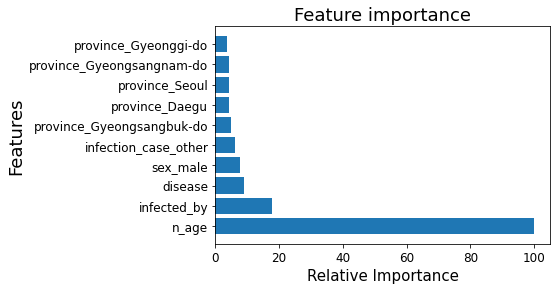

In [75]:
print('Top 10 (+ve correlation)')
print(feature_importances.head(10))

_plt=plt.barh(y='features', width='importance', data=feature_importances.head(10), align='center')
_plt=plt.xlabel('Relative Importance',fontsize=15)
_plt=plt.ylabel('Features',fontsize=18)
_plt=plt.yticks(fontsize=12)
_plt=plt.xticks(fontsize=12)
_plt=plt.title('Feature importance',fontsize=18)

Top 10 (-ve correlation)
                      features  importance
18       province_Jeollabuk-do    1.384417
12            province_Gwangju    1.383921
11         province_Gangwon-do    1.321493
20             province_Sejong    1.279402
16            province_Incheon    1.167957
19       province_Jeollanam-do    1.040639
7   province_Chungcheongbuk-do    0.803015
5             country_Mongolia    0.310188
17            province_Jeju-do    0.274678
6             country_Thailand    0.029530


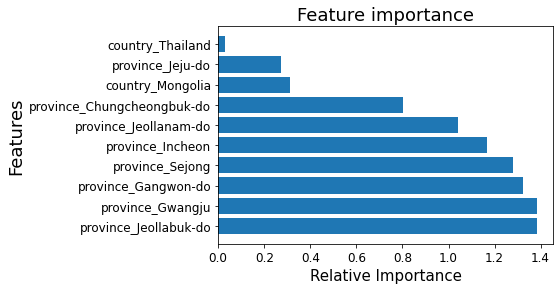

In [76]:
print('Top 10 (-ve correlation)')
print(feature_importances.tail(10))
_plt=plt.barh(y='features', width='importance', data=feature_importances.tail(10), align='center')
_plt=plt.xlabel('Relative Importance',fontsize=15)
_plt=plt.ylabel('Features',fontsize=18)
_plt=plt.yticks(fontsize=12)
_plt=plt.xticks(fontsize=12)
_plt=plt.title('Feature importance',fontsize=18)

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.